# K-Means

In [90]:
# Import libraries
import glob
import numpy as np
import PIL.Image as Image
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance


In [86]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    # Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)
    
    return a_bins

# Calculates Wasserstein distance of two images
def wasserstein(x, y): 
    return stats.wasserstein_distance(np.arange(len(x)), np.arange(len(y)), x, y)


In [123]:
# Initialize K Means methods
def init_centroids(data, k):
    row, col = data.shape
    centroids = np.empty([k, col])
    
    for i in range(k):
        index = np.random.randint(row)
        centroids[i] = data[index]
    
    return centroids

def euclid_dist(x, y):
    xSquare = np.sum(np.square(x), axis = 1)
    ySquare = np.sum(np.square(y), axis = 1)
    mul = np.dot(x, y.T)
    dists = np.sqrt(abs(xSquare[:, np.newaxis] + ySquare - 2 * mul))
    return dists

def wasserstein_dist(x, y):
    sol = np.zeros((x.shape[0], y.shape[0]))
    for i, a in enumerate(x):
        for j, b in enumerate(y):
           sol[i, j] = stats.wasserstein_distance(a, b)
    return sol

def update_assignment(centers, data):
    row, col = data.shape
    clust = np.empty([row])
    distances = euclid_dist(data, centers)
    clust = np.argmin(distances, axis = 1)
    
    return clust

def update_centroids(centers, data, clusts):
    k, d = centers.shape
    new_centers = np.empty(centers.shape)
    for i in range(k):
        new_centers[i] = np.mean(data[clusts == i], axis = 0)

    return new_centers

def calculate_loss(centers, clust, data):
    distances = euclid_dist(data, centers)
    loss = 0.0 
    row, col = data.shape

    for i in range(row):
        loss = loss + np.square(distances[i][clust[i]])

    return loss

def kmeans(data, k, max_iters = 100, abs_tol = 1e-16, rel_tol = 1e-16):
    centroids = init_centroids(data, k)

    for it in range(max_iters):
        clusts = update_assignment(centroids, data)
        centroids = update_centroids(centroids, data, clusts)
        loss = calculate_loss(centroids, clusts, data)
        k = centroids.shape[0]
        if it:
            diff = np.abs(prev_loss - loss)
            if diff < abs_tol and diff / prev_loss < rel_tol:
                break
        prev_loss = loss

    return clusts, centroids, loss

def nearest_neighbors(data, sample, k, images):
    distances = []
    neighbors = []

    for j, i in enumerate(data):
        distances.append((distance.euclidean(sample, i), j))
    
    distances = sorted(distances)

    for i in range(k + 1):
        neighbors.append(images[distances[i][1]])
    
    return neighbors


In [45]:
# Determine optimal k with elbow method
def calculate_WSS(points):
  sse = []
  for k in range(1, 11):
    kmeans = cluster.KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [46]:
# Collect all images in AIA171_Miniset_BW and represent them as numpy arrays
images = []
x = []
image_paths = glob.glob('./../../AIA171_Miniset_BW/**/*.jpg', recursive = True)
for image_path in image_paths:
    image = np.array(Image.open(image_path).convert('L'))
    image = image.astype(float) / 255
    images.append(image)
    x.append(power_spectrum_1d(image))
images = np.array(images)
x = np.array(x)   


c:\Users\starf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\starf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\starf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\starf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

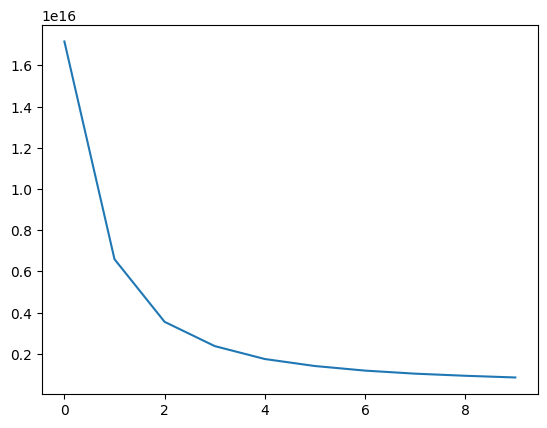

In [47]:
# Determine optimal K-Means
clust = calculate_WSS(x)
plt.plot(clust)
plt.show()


c:\Users\starf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


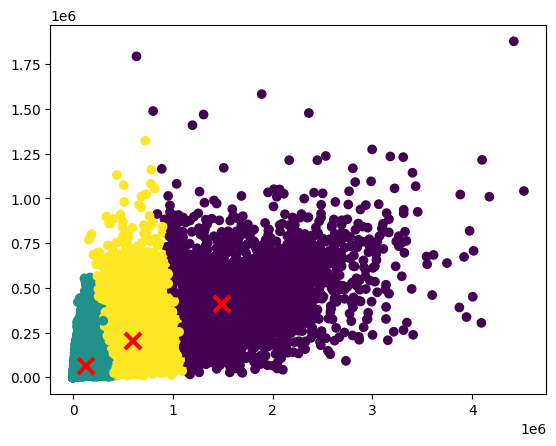

In [48]:
# Perform K-Means with scikit-learn
clust = cluster.KMeans(3).fit(x)
plt.scatter(x[:,0], x[:,1], c = clust.predict(x))
plt.plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3)
plt.show()


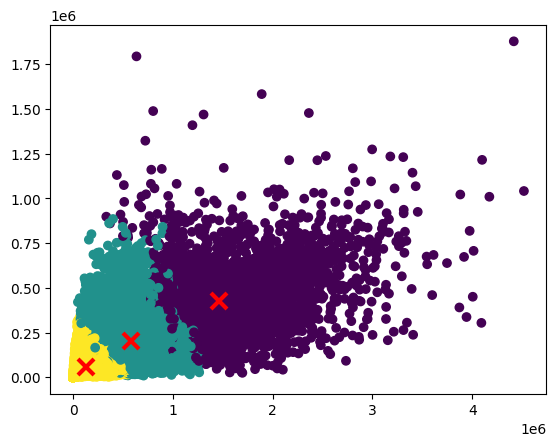

In [ ]:
clust, centers, _ = kmeans(x, 3)
plt.scatter(x[:,0], x[:,1], c = clust)
plt.plot(centers[:,0], centers[:,1], 'rx', ms = 12, mew = 3)
plt.show()


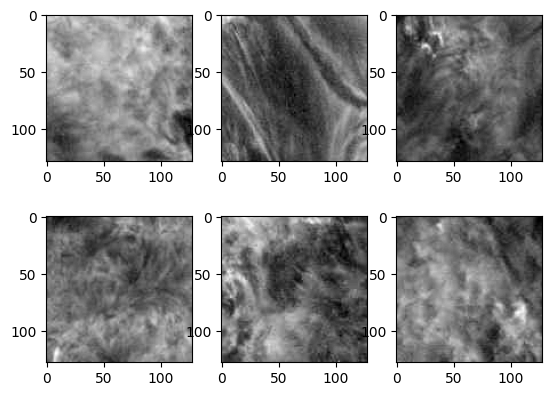

In [129]:
index = np.random.randint(len(x))

neighbors = nearest_neighbors(x, x[index], 5, images)

fig, ax = plt.subplots(2, 3)
ax[0][0].imshow(neighbors[0], cmap = 'gray')
ax[0][1].imshow(neighbors[1], cmap = 'gray')
ax[0][2].imshow(neighbors[2], cmap = 'gray')
ax[1][0].imshow(neighbors[3], cmap = 'gray')
ax[1][1].imshow(neighbors[4], cmap = 'gray')
ax[1][2].imshow(neighbors[5], cmap = 'gray')